In [2]:
import pandas as pd
import numpy as np
from os import walk
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
#Load libraries
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

In [4]:
#Read airline cancelled flight file for year 2003
df_flight = pd.read_csv("2003.csv")

C:\Users\itiag\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Filter out unimportant columns
df_flight = df_flight[['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'UniqueCarrier',                    
 'CRSArrTime',                     
 'CRSDepTime',  
 'Distance',
 'Cancelled' ]]

df_flight.head(5)

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSArrTime,CRSDepTime,Distance,Cancelled
0,2003,1,29,3,UA,1913,1655,837,0
1,2003,1,30,4,UA,1913,1655,837,0
2,2003,1,31,5,UA,1913,1655,837,0
3,2003,1,1,3,UA,1634,1035,1835,0
4,2003,1,2,4,UA,1634,1035,1835,0


In [6]:
# How much of your data is missing?
df_flight.isnull().sum().sort_values(ascending=False).head()

Cancelled        0
Distance         0
CRSDepTime       0
CRSArrTime       0
UniqueCarrier    0
dtype: int64

In [7]:
#Plot percentage of flights cancelled by Airline Carrier

#Read the Carrier Key CSV file for full names of the Airlines
carrier_key = pd.read_csv('carriers.csv')

carrier_delay = pd.DataFrame()

for UC in list(df_flight['UniqueCarrier'].unique()):
    perc_delayed = len(df_flight[(df_flight['UniqueCarrier']==UC) & (df_flight['Cancelled']==1)].index)/len(df_flight[df_flight['UniqueCarrier']==UC].index)*100
    carrier_delay = carrier_delay.append({'UniqueCarrier':UC,'percent_cancelled' : perc_delayed},ignore_index=True)

carrier_delay = pd.merge(carrier_delay,carrier_key,how='left',left_on='UniqueCarrier', right_on='Code')
carrier_delay.drop(['UniqueCarrier','Code'],axis=1,inplace=True)
carrier_delay.rename(index=str,columns={'Description':'Airline'},inplace=True)
#Sort by percentage cancelled
carrier_delay.sort_values(by = ['percent_cancelled'],ascending=False,inplace=True)

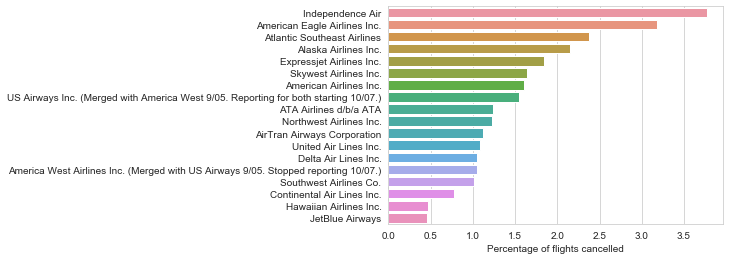

In [8]:
color_pal = sns.color_palette("OrRd", len(carrier_delay.index))
color_pal = color_pal[::-1]

plt.figure(figsize=(6, 4))
g = sns.barplot(x="percent_cancelled", y="Airline", data=carrier_delay)
g.set_ylabel('')
g.set_xlabel('Percentage of flights cancelled')
fig = g.get_figure()
fig.savefig("carrier_cancelled.png", bbox_inches='tight')

In [9]:
del carrier_delay

In [10]:
# class distribution
df_flight.groupby('Cancelled').size()

Cancelled
0    6387071
1     101469
dtype: int64

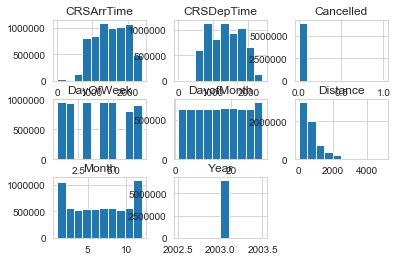

In [11]:
# histograms
df_flight.hist()
pyplot.show()

In [13]:
# Assign X as a DataFrame of features and y as a Series of the outcome variable
X = df_flight.drop('Cancelled', 1)
y = df_flight.Cancelled

In [16]:
# 'UniqueCarrier' and observations
print(X['UniqueCarrier'].value_counts().sort_values(ascending=False))

WN    958566
AA    752241
DL    660617
UA    543957
NW    499160
MQ    429098
US    411956
OO    396801
XE    328086
CO    302742
DH    291600
EV    273712
HP    189519
AS    161594
FL    144700
TZ     69176
B6     67184
HA      7831
Name: UniqueCarrier, dtype: int64


In [17]:
# Function to dummy all the categorical variables used for modeling
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [19]:
X = dummy_df(X, ['UniqueCarrier'])
print(X.head(5))

   Year  Month  DayofMonth  DayOfWeek  CRSArrTime  CRSDepTime  Distance  \
0  2003      1          29          3        1913        1655       837   
1  2003      1          30          4        1913        1655       837   
2  2003      1          31          5        1913        1655       837   
3  2003      1           1          3        1634        1035      1835   
4  2003      1           2          4        1634        1035      1835   

   UniqueCarrier_AA  UniqueCarrier_AS  UniqueCarrier_B6  ...  \
0                 0                 0                 0  ...   
1                 0                 0                 0  ...   
2                 0                 0                 0  ...   
3                 0                 0                 0  ...   
4                 0                 0                 0  ...   

   UniqueCarrier_HA  UniqueCarrier_HP  UniqueCarrier_MQ  UniqueCarrier_NW  \
0                 0                 0                 0                 0   
1         

In [20]:
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [21]:
tukey_indices, tukey_values = find_outliers_tukey(X['Distance'])
print(np.sort(tukey_values))

[1911 1911 1911 ... 4962 4962 4962]


In [45]:
# Use pyplot in matplotlib to plot histograms
%matplotlib inline
import matplotlib.pyplot as plt
# Plot histograms to show distribution of features by outcome categories
def plot_histogram_dv(x,y):
    plt.hist(list(x[y==0]), alpha=0.5, label='Outcome=Not Cancelled')
    plt.hist(list(x[y==1]), alpha=0.5, label='Outcome=Cancelled')
    plt.title("Histogram of '{var_name}' by Outcome Category ".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

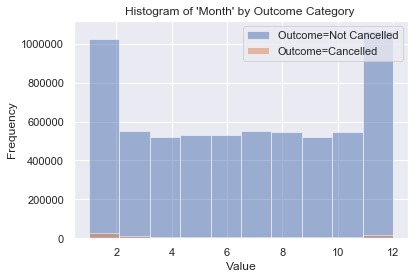

In [46]:
plot_histogram_dv(X['Month'], y)

In [49]:
# Use train_test_split in sklearn.model_selection to split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(5190832, 25) (5190832,)
(1297708, 25) (1297708,)


In [27]:
# Init the Gaussian Classifier
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [28]:
# Train the model
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [29]:
# Predict Output 
pred = model.predict(X_test)
print(pred[:5])

[0 1 0 0 0]


In [53]:
print ('Score:'), model.score(X_test, y_test)

Score:


(None, 0.8179289948123923)

Text(89.18, 0.5, 'Predicted')

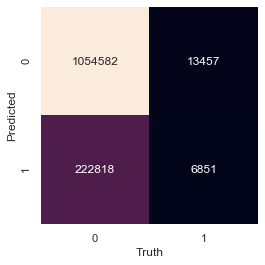

In [47]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
mat = confusion_matrix(pred, y_test)
names = np.unique(pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')